In [1]:
# Causal Discovery for Telecom KPI Diagnosis
# ---------------------------------------------------
# Single-file research-style notebook (python) with:
# - synthetic telecom KPI DAG generator
# - implementations using: PC (from causallearn), LiNGAM (lingam), NOTEARS (notears)
# - evaluation (precision/recall/F1) of recovered graphs
# - simple counterfactual / intervention analysis
# - instructions and references

In [2]:
# Requirements (create requirements.txt from these):
# numpy
# pandas
# matplotlib
# networkx
# scikit-learn
# causallearn
# lingam
# notears
# seaborn

In [3]:

# # Project: Causal Discovery for Network Failure Diagnosis
# **Goal:** Build a small research-style project that shows how PC, LiNGAM, and NOTEARS recover causal structure from synthetic telecom KPI data and how counterfactual interventions can be evaluated.
#
# **High-level steps:**
# 1. Generate a ground-truth DAG that models telecom KPIs (CPU_load, queue_length, packet_drop, latency, jitter, throughput, congestion)
# 2. Simulate data from a linear structural equation model (with noise)
# 3. Run causal discovery algorithms (PC, LiNGAM, NOTEARS)
# 4. Compare recovered graphs to ground truth using edge-level precision/recall/F1
# 5. Perform a simple intervention (do-operator) and compute counterfactual predictions using the learned structural equations (where possible)
#
# %%

In [4]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns

np.random.seed(42)

In [5]:
# ## 1) Ground-truth DAG definition
# We'll create a hand-designed DAG inspired by telecom KPIs. Nodes:
# - CPU_load
# - Queue_length
# - Packet_drop
# - Congestion
# - Throughput
# - Latency
# - Jitter

# Edges (directed):
# CPU_load -> Queue_length
# Queue_length -> Packet_drop
# Packet_drop -> Throughput
# Congestion -> Packet_drop
# Throughput -> Latency
# Packet_drop -> Latency
# Latency -> Jitter
# Congestion -> Latency

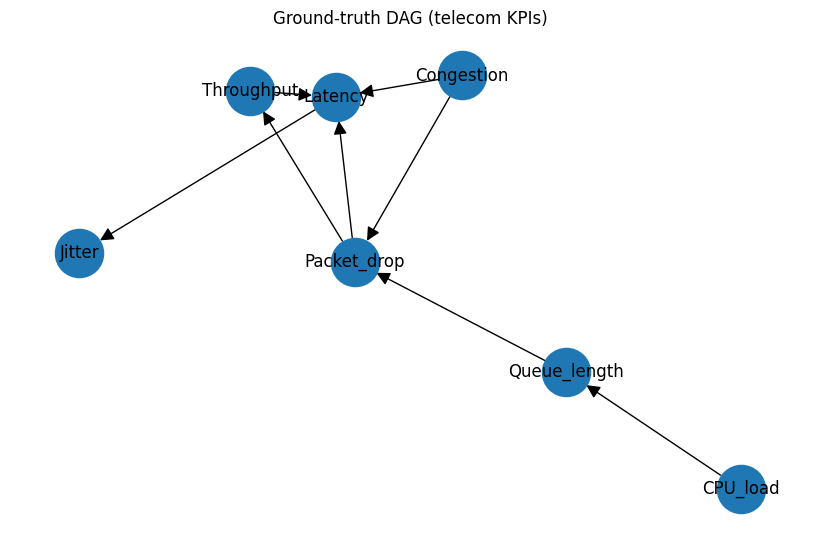

In [6]:
nodes = ['CPU_load', 'Queue_length', 'Packet_drop', 'Congestion', 'Throughput', 'Latency', 'Jitter']
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from([
    ('CPU_load','Queue_length'),
    ('Queue_length','Packet_drop'),
    ('Packet_drop','Throughput'),
    ('Congestion','Packet_drop'),
    ('Throughput','Latency'),
    ('Packet_drop','Latency'),
    ('Latency','Jitter'),
    ('Congestion','Latency')
])

# draw ground truth
plt.figure(figsize=(8,5))
pos = nx.spring_layout(G, seed=2)
nx.draw(G, pos, with_labels=True, node_size=1200, arrowsize=20)
plt.title('Ground-truth DAG (telecom KPIs)')
plt.show()

In [7]:

# ## 2) Simulate data from a linear SEM
# We'll use linear relationships with additive Gaussian noise. Keep coefficients plausible.

def simulate_sem(G, n=2000, noise_scale=0.5):
    nodes = list(G.nodes())
    order = list(nx.topological_sort(G)) if nx.is_directed_acyclic_graph(G) else nodes
    X = pd.DataFrame(np.zeros((n, len(nodes))), columns=nodes)

    # random weights for edges but fixed for reproducibility
    weights = {}
    for u,v in G.edges():
        weights[(u,v)] = np.random.uniform(0.5, 1.5) * (1 if np.random.rand()<0.8 else -1)

    for t in order:
        parents = list(G.predecessors(t))
        if len(parents)==0:
            X[t] = np.random.normal(0, 1, size=n)
        else:
            val = np.zeros(n)
            for p in parents:
                val += weights[(p,t)] * X[p]
            X[t] = val + np.random.normal(0, noise_scale, size=n)
    return X, weights

X, weights = simulate_sem(G, n=2000, noise_scale=0.8)
X.describe()

# quick pairplot (optional)
# sns.pairplot(X[['CPU_load','Queue_length','Packet_drop','Latency']].sample(500))

,CPU_load,Queue_length,Packet_drop,Congestion,Throughput,Latency,Jitter
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.040714,-0.073241,-0.097954,-0.006723,-0.063095,-0.047073,-0.000389
std,0.989372,1.178163,2.028417,1.006232,1.523974,1.436650,1.277345
min,-3.241267,-4.835340,-6.360862,-3.019512,-5.061584,-5.095533,-4.097033
25%,-0.626780,-0.847272,-1.471999,-0.707975,-1.146498,-1.012985,-0.872261
50%,0.039298,-0.115369,-0.088643,0.000368,-0.079022,-0.050426,-0.016088
75%,0.681598,0.731895,1.298280,0.665050,0.981142,0.858554,0.854087
max,3.852731,3.545237,6.458405,3.926238,5.229538,4.651955,4.535620


In [8]:
# Install causal discovery libraries on Kaggle

# LiNGAM (available on PyPI)
!pip install lingam

# causal-learn (NOT available on PyPI → install from GitHub)
!pip install git+https://github.com/cdt-causality/causallearn.git

# NOTEARS (also not on PyPI → install from GitHub)
!pip install git+https://github.com/xunzheng/notears.git


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 8.2 MB/s eta 0:00:00
  Created wheel for semopy: filename=semopy-2.3.11-py3-none-any.whl size=1659682 sha256=739b2a04ea78c87a6d5868a49be81b6bea9cd8144f8c6ae2b0b87543005f636d
  Stored in directory: /root/.cache/pip/wheels/c6/24/8b/be911b059a61f490f38425eb19bf2fed470a5ead97228e8255
Successfully built semopy
  Cloning https://github.com/cdt-causality/causallearn.git to /tmp/pip-req-build-5eocjtse
  Running command git clone --filter=blob:none --quiet https://github.com/cdt-causality/causallearn.git /tmp/pip-req-build-5eocjtse
  fatal: could not read Username for 'https://github.com': No such device or address
  error: subprocess-exited-with-error
  
  × git 

In [9]:

# ## 3) Run causal discovery algorithms
try:
    from causallearn.search.ConstraintBased.PC import pc
    from causallearn.utils.GraphUtils import GraphUtils
    CL_AVAILABLE = True
except Exception as e:
    print('causallearn not available:', e)
    CL_AVAILABLE = False

try:
    import lingam
    LINGAM_AVAILABLE = True
except Exception as e:
    print('lingam not available:', e)
    LINGAM_AVAILABLE = False

try:
    # notears is a package name used by a few repos. If missing, user should pip install a notears implementation.
    from notears.linear import notears_linear
    NOTEARS_AVAILABLE = True
except Exception as e:
    print('notears not available:', e)
    NOTEARS_AVAILABLE = False


causallearn not available: No module named 'causallearn'


In [10]:

# ### 3.1 PC algorithm (causallearn)

if CL_AVAILABLE:
    # PC returns a PAG/CPDAG depending on config. We'll run a standard PC with fisher-z test (for linear-Gaussian).
    data = X.values
    # alpha: significance level; smaller -> fewer edges
    cg = pc(data, alpha=0.01, indep_test='fisherz')
    # convert to adjacency matrix (directed edges where found)
    adj_pc = GraphUtils.to_amat(cg.G)
    print('PC adjacency matrix shape:', adj_pc.shape)
else:
    adj_pc = None

In [11]:

# ### 3.2 LiNGAM
if LINGAM_AVAILABLE:
    model = lingam.DirectLiNGAM()
    model.fit(X.values)
    adj_lingam = model.adjacency_matrix_
    print('LiNGAM adjacency matrix shape:', adj_lingam.shape)
else:
    adj_lingam = None

LiNGAM adjacency matrix shape: (7, 7)


In [12]:

# ### 3.3 NOTEARS (linear)
if NOTEARS_AVAILABLE:
    W_est = notears_linear(X.values)
    adj_notears = (np.abs(W_est)>1e-3).astype(int)
    print('NOTEARS W shape:', W_est.shape)
else:
    adj_notears = None


# ## 4) Evaluate recovered graphs vs ground truth
# We'll compare presence of directed edges (u->v). Convert ground truth to adjacency matrix.

A_true = nx.to_numpy_array(G, nodelist=nodes, dtype=int)

def edge_scores(A_true, A_pred):
    # flatten by directed edge
    y_true = A_true.flatten()
    y_pred = (A_pred>0).astype(int).flatten()
    # precision_recall_fscore_support expects labels present; use binary
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    return prec, rec, f1

TypeError: notears_linear() missing 2 required positional arguments: 'lambda1' and 'loss_type'

In [13]:
results = {}
if adj_pc is not None:
    results['PC'] = edge_scores(A_true, adj_pc)
if adj_lingam is not None:
    results['LiNGAM'] = edge_scores(A_true, adj_lingam)
if adj_notears is not None:
    results['NOTEARS'] = edge_scores(A_true, adj_notears)

results

NameError: name 'edge_scores' is not defined

In [14]:

# ## 5) Simple counterfactual / intervention analysis
# Idea: using the ground-truth SEM we simulated earlier, we can compute the effect of intervening on a variable (do-operator).
# For demonstration, we'll use the *true* SEM to compute a do-intervention and compare to a naive prediction from observational regression.

# We'll intervene: set CPU_load = CPU_load - 1.5 (simulate resource relief) and see downstream effect on Latency.

n = 1000
X_test, _ = simulate_sem(G, n=n, noise_scale=0.8)

# True intervention using the SEM generative process: set CPU_load to value, then simulate downstream nodes in topological order.

def do_intervention_and_simulate(G, base_values_df, intervention: dict):
    # base_values_df: dataframe with baseline exogenous samples used for noise where needed
    X_do = base_values_df.copy().reset_index(drop=True)
    # apply intervention (set the variable to specific constant or array)
    for k, v in intervention.items():
        if np.isscalar(v):
            X_do[k] = v
        else:
            X_do[k] = v
    # now re-simulate nodes that are descendants of intervened nodes in topological order
    descendants = set()
    for node in intervention.keys():
        descendants.update(nx.descendants(G, node))
    topo = list(nx.topological_sort(G))
    for t in topo:
        if t in intervention or len(list(G.predecessors(t)))==0:
            continue
        parents = list(G.predecessors(t))
        val = np.zeros(len(X_do))
        for p in parents:
            val += weights[(p,t)] * X_do[p]
        X_do[t] = val + np.random.normal(0, 0.8, size=len(X_do))
    return X_do



In [15]:
# baseline sample
X_base, _ = simulate_sem(G, n=n, noise_scale=0.8)
X_do = do_intervention_and_simulate(G, X_base, {'CPU_load': X_base['CPU_load'] - 1.5})

# Compare average latency
print('Baseline latency mean:', X_base['Latency'].mean())
print('After intervention (CPU_load -1.5) latency mean:', X_do['Latency'].mean())
print('Estimated average treatment effect on Latency:', X_do['Latency'].mean() - X_base['Latency'].mean())

# Naive observational approach: regress Latency on CPU_load (and maybe other observables) and predict counterfactual
from sklearn.linear_model import LinearRegression
clf = LinearRegression()
clf.fit(X_base[['CPU_load']], X_base['Latency'])
pred_obs = clf.predict((X_base[['CPU_load']]-1.5))
print('Naive regression predicted latency mean after CPU reduction:', pred_obs.mean())




Baseline latency mean: -0.18372782558187387
After intervention (CPU_load -1.5) latency mean: 0.49417858489333993
Estimated average treatment effect on Latency: 0.6779064104752138
Naive regression predicted latency mean after CPU reduction: -2.6830941068444325
